# Global Super Store Dataset

## Info
- **Nomes:** Carlos Machado e João Felipe
- **Base:** [Global Super Store Dataset](https://www.kaggle.com/apoorvaappz/global-super-store-dataset)
- **Descrição:** Essa base de dados contém os detalhes de pedidos feitos online por pessoas em todo o mundo no período de 1 de janeiro de 2011 a 31 de dezembro de 2014. Não há valores ausentes na maioria das colunas, exceto o código postal, mas a princípio é um dado descartável.
- **Quantidade de atributos:** 22
- **Quantidade de registros:** 51.3k

## Visualização dos dados
1. Qual é o lucro por região, mercado, categorias gerais e segmento? E quais países e categorias dão mais e menos lucros?
1. Qual é o valor de vendas por região, mercado, categorias gerais e segmento? E quais países e categorias com os maiores e menores valores de vendas?
1. Qual é a quantidade de pedidos por região, mercado, categorias gerais e segmento? E quais países e categorias com mais e menos pedidos?
1. Quais as categorias predominantes em cada região?
1. Existem preferências no método de envio? E qual o método de envio predominante em cada região?

## Perguntas (Problemas de negócios)
1. Quais os atributos que impactam nos lucros? (Classificação)
1. Existem categorias que são costumeiramente vendidas juntas? (Associação)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Inicialização

Carrega bibliotecas

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import os
import csv
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np  
import pandas as pd
import requests as rq
import json
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

Variáveis de controle

In [ ]:
# Json de relação entre país x região (True: carrega do drive / False: gera um novo)
LOAD_COUNTRY_REGION_JSON = True
# Dados já normalizados (True: carrega do drive / False: gera um novo)
LOAD_PATTERN_JSON = True

drive_path = '/content/drive/MyDrive/Colab Notebooks/KDD_BD2'
file_ext = '.csv'


if LOAD_PATTERN_JSON:
  base_name = 'dataset_padronizado'
  base_path = os.path.join(drive_path, base_name + file_ext)

  # carregando a base de dados
  data = pd.read_csv(base_path)
else:
  base_name = 'dataset'
  base_path = os.path.join(drive_path, base_name + file_ext)

  # carregando a base de dados
  data = pd.read_csv(base_path)

## Visualização da base

In [ ]:
data.shape

(0, 23)

In [ ]:
data.isnull().sum()

row_id              0
order_id            0
order_date          0
ship_date           0
ship_mode           0
customer_id         0
segment             0
city                0
state               0
country             0
market              0
region              0
product_id          0
general_category    0
category            0
product_name        0
sales               0
quantity            0
discount            0
profit              0
shipping_cost       0
order_priority      0
global_region       0
dtype: int64

In [ ]:
data.head()

,order_id,order_date,ship_date,ship_mode,customer_id,segment,city,state,country,market,region,product_id,general_category,category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority,global_region,orders
row_id,,,,,,,,,,,,,,,,,,,,,,,
32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Consumer,New York City,New York,United States of America,US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical,Americas,1
26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Corporate,Wollongong,New South Wales,Australia,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical,Oceania,1
25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Consumer,Brisbane,Queensland,Australia,APAC,Oceania,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium,Oceania,1
13524,ES-2013-1579342,28-01-2013,30-01-2013,First Class,KM-16375,Home Office,Berlin,Berlin,Germany,EU,Central,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium,Europe,1
47221,SG-2013-4320,05-11-2013,06-11-2013,Same Day,RH-9495,Consumer,Dakar,Dakar,Senegal,Africa,Africa,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical,Africa,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   row_id          0 non-null      int64  
 1   order_id        0 non-null      object 
 2   order_date      0 non-null      object 
 3   ship_date       0 non-null      object 
 4   ship_mode       0 non-null      object 
 5   customer_id     0 non-null      object 
 6   segment         0 non-null      object 
 7   city            0 non-null      object 
 8   state           0 non-null      object 
 9   country         0 non-null      object 
 10  market          0 non-null      object 
 11  region          0 non-null      object 
 12  product_id      0 non-null      object 
 13  category        0 non-null      object 
 14  subcategory     0 non-null      object 
 15  product_name    0 non-null      object 
 16  sales           0 non-null      float64
 17  quantity        0 non-null      int64  
 18  di

In [ ]:
data.describe(include='all')

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,segment,city,state,country,market,region,product_id,general_category,category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority,global_region
count,51290.00000,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000,51290,51290
unique,NaN,25035,1430,1464,4,1590,3,3636,1094,147,7,13,10292,3,17,3788,NaN,NaN,NaN,NaN,NaN,4,5
top,NaN,CA-2014-100111,18-06-2014,22-11-2014,Standard Class,PO-18850,Consumer,New York City,California,United States of America,APAC,Central,OFF-AR-10003651,Office Supplies,Binders,Staples,NaN,NaN,NaN,NaN,NaN,Medium,Americas
freq,NaN,14,135,130,30775,97,26518,915,2001,9994,11002,11117,35,31273,6152,227,NaN,NaN,NaN,NaN,NaN,29433,20672
mean,25645.50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,246.490581,3.476545,0.142908,28.610982,26.375915,NaN,NaN
std,14806.29199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,487.565361,2.278766,0.212280,174.340972,57.296804,NaN,NaN
min,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.444000,1.000000,0.000000,-6599.978000,0.000000,NaN,NaN
25%,12823.25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.758625,2.000000,0.000000,0.000000,2.610000,NaN,NaN
50%,25645.50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.053000,3.000000,0.000000,9.240000,7.790000,NaN,NaN
75%,38467.75000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,251.053200,5.000000,0.200000,36.810000,24.450000,NaN,NaN


In [ ]:
data.nunique()

row_id              51290
order_id            25035
order_date           1430
ship_date            1464
ship_mode               4
customer_id          1590
segment                 3
city                 3636
state                1094
country               147
market                  7
region                 13
product_id          10292
general_category        3
category               17
product_name         3788
sales               22995
quantity               14
discount               27
profit              24575
shipping_cost       10037
order_priority          4
global_region           5
dtype: int64

## Pré-processamento

In [ ]:
# removendo espaços dos nomes das colunas
data.columns = data.columns.str.replace(' ', '_')
data.columns = data.columns.str.replace('-', '')
data.columns = data.columns.str.lower()

# removendo colunas não utilizáveis
data.pop('postal_code')
data.pop('customer_name')

# renomeando colunas
data.rename(columns={'category': 'general_category'}, inplace = True)
data.rename(columns={'subcategory': 'category'}, inplace = True)

data['product_name'] = data['product_name'].str.split(',').str[0]

# adicionando coluna região
# preparando nomes para a api
data.loc[data.country == 'United States', 'country'] = 'United States of America'
data.loc[data.country == 'Tanzania', 'country'] = 'Tanzania, United Republic of'
data.loc[data.country == 'United Kingdom', 'country'] = 'United Kingdom of Great Britain and Northern Ireland'
data.loc[data.country == 'Democratic Republic of the Congo', 'country'] = 'Congo (Democratic Republic of the)'
data.loc[data.country == 'Republic of the Congo', 'country'] = 'Congo'
data.loc[data.country == 'Iran', 'country'] = 'Iran (Islamic Republic of)'
data.loc[data.country == 'Russia', 'country'] = 'Russian Federation'
data.loc[data.country == 'Vietnam', 'country'] = 'Viet Nam'
data.loc[data.country == 'Myanmar (Burma)', 'country'] = 'Myanmar'
data.loc[data.country == 'South Korea', 'country'] = 'Korea (Republic of)'
data.loc[data.country == 'Bolivia', 'country'] = 'Bolivia (Plurinational State of)'
data.loc[data.country == 'Syria', 'country'] = 'Syrian Arab Republic'
data.loc[data.country == 'Venezuela', 'country'] = 'Venezuela (Bolivarian Republic of)'
data.loc[data.country == 'Moldova', 'country'] = 'Moldova (Republic of)'
data.loc[data.country == 'Macedonia', 'country'] = 'Macedonia (the former Yugoslav Republic of)'
data.describe()

region_dict = {}

if LOAD_COUNTRY_REGION_JSON:
  # carrega o arquivo json contendo pais e região
  with open(os.path.join(drive_path, 'country_region.json'), mode='r') as f:
      region_dict = json.load(f)
else:
  # gera o arquivo json contendo pais e região
  countries = data['country'].unique()
  for country in countries:
    region_dict[country] = rq.get('https://restcountries.eu/rest/v2/name/{}?fullText=true'.format(country)).json()[0]['region']

  with open(os.path.join(drive_path, 'country_region.json'), mode='w') as f:
      json.dump(region_dict, f)

for index, row in data.iterrows():
  data.loc[index, 'global_region'] = region_dict[data.at[index, 'country']]

# salva o dataset já padronizado
data.to_csv(os.path.join(drive_path, 'dataset_padronizado' + file_ext), index=False)
data.set_index('order_id')

KeyError: ignored

## Visualização dos dados

#### Funções úteis

In [ ]:
def plot_sum_by(df, sum, cat, h=None, revf=False, kind='bar', figsize=(8, 4.5)):
  subdata = pd.DataFrame()
  subdata[sum] = df[sum]
  subdata[cat] = df[cat]
  subdata = subdata.groupby(cat)[sum].sum().reset_index()
  if revf:
    subdata = subdata.sort_values(sum, ascending=False)
  if h != None and revf:
    subdata = subdata.head(h)
  subdata.set_index(sum)
  subdata = subdata.sort_values(sum)
  if h != None and not revf:
    subdata = subdata.head(h)
  subdata.plot(x=cat, kind=kind, figsize=figsize)

#### 1. Qual é o lucro por região, mercado, categorias gerais e segmento? E quais países e categorias dão mais e menos lucros?

Lucro por região

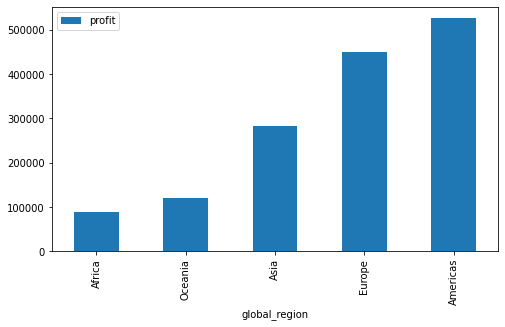

In [ ]:
plot_sum_by(data, 'profit', 'global_region')

Lucro por mercado

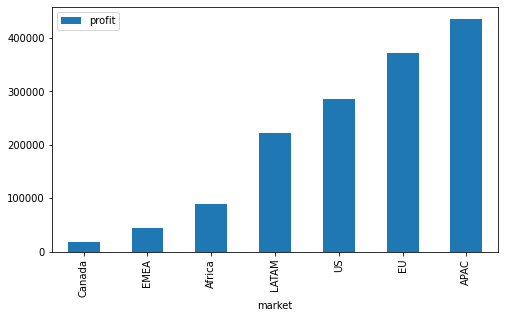

In [ ]:
plot_sum_by(data, 'profit', 'market')

Lucro por categorias gerais

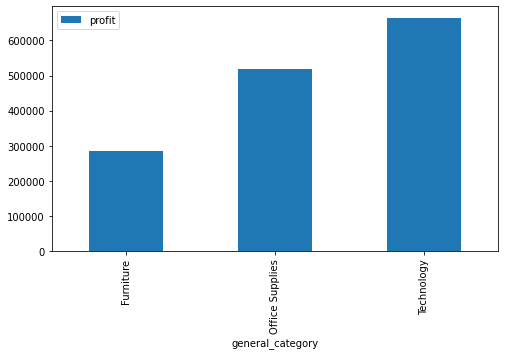

In [ ]:
plot_sum_by(data, 'profit', 'general_category')

Países que dão mais lucro

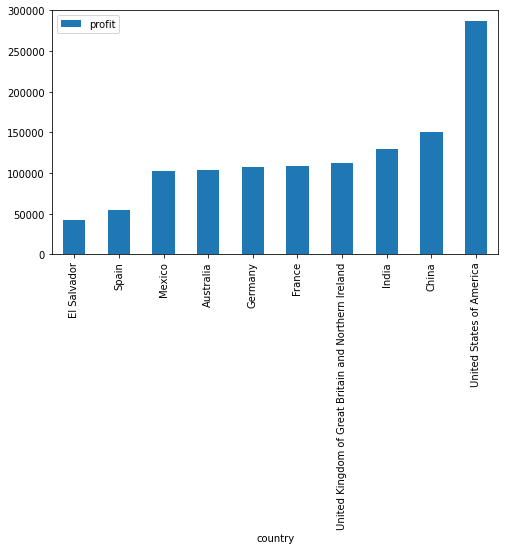

In [ ]:
plot_sum_by(data, 'profit', 'country', 10, True)

Países que dão menos lucros

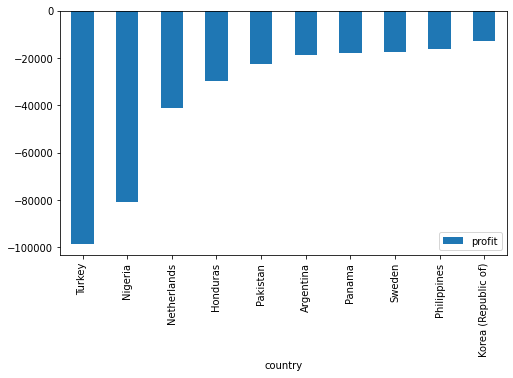

In [ ]:
plot_sum_by(data, 'profit', 'country', 10)

Categorias que dão mais lucro

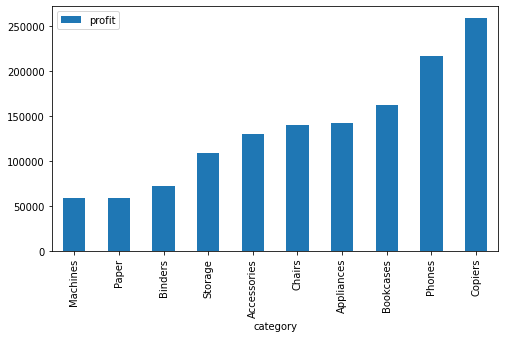

In [ ]:
triplot_sum_by(data, 'profit', 'category', 10, True)

Categorias que dão menos lucros

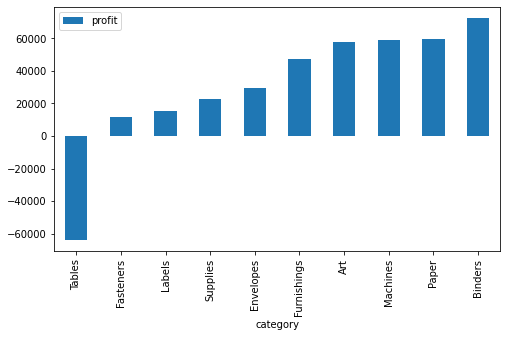

In [ ]:
plot_sum_by(data, 'profit', 'category', 10)

Lucro por trimestre

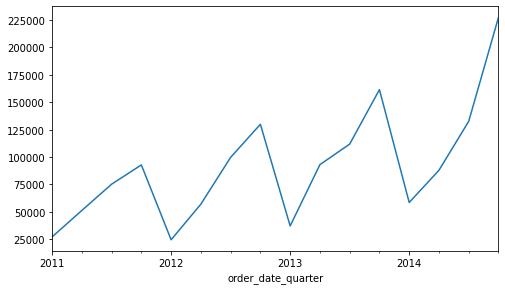

In [ ]:
subdata = pd.DataFrame()
subdata['order_date_quarter'] = pd.PeriodIndex(pd.to_datetime(data['order_date'].sort_values(ascending=False)), freq='Q')
subdata['profit'] = data['profit']
subdata = subdata.groupby('order_date_quarter')['profit'].sum()
subdata.plot(figsize=(8, 4.5))

#### 2. Qual é o valor de vendas por região, mercado, categorias gerais e segmento? E quais países e categorias os maiores e menores valores de vendas?

Valor de vendas por região

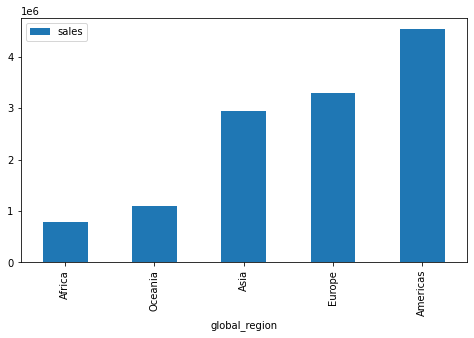

In [ ]:
plot_sum_by(data, 'sales', 'global_region')

Valor de vendas por mercado

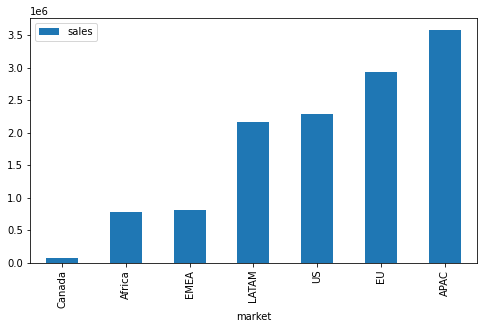

In [ ]:
plot_sum_by(data, 'sales', 'market')

Valor de vendas por categorias gerais

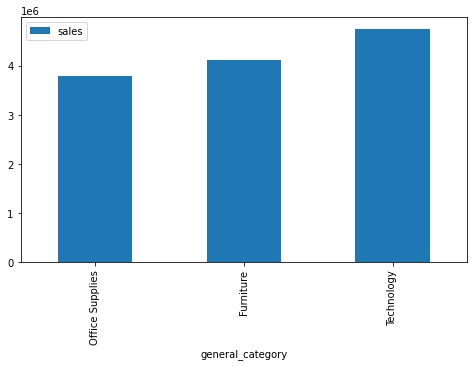

In [ ]:
plot_sum_by(data, 'sales', 'general_category')

Países com os maiores valores de vendas

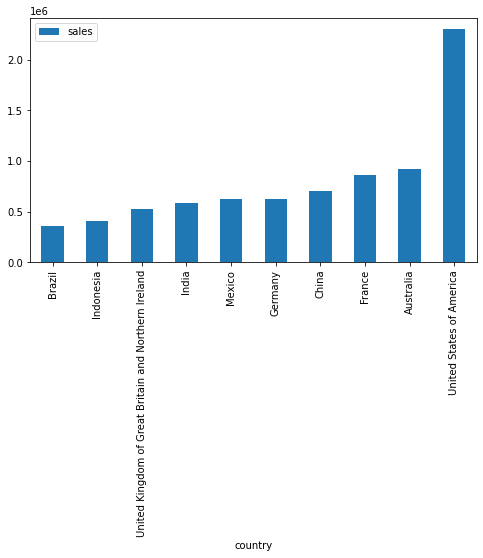

In [ ]:
plot_sum_by(data, 'sales', 'country', 10, True)

Países com os menores valores de vendas

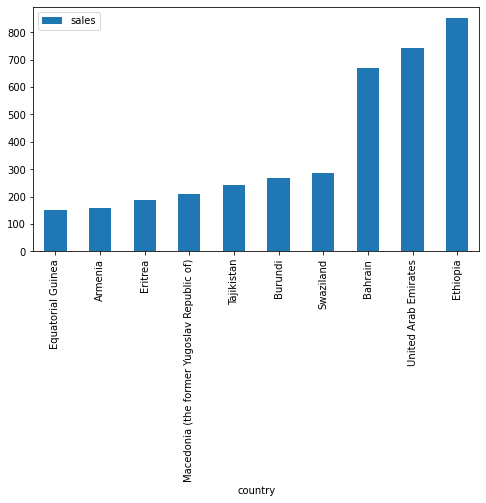

In [ ]:
plot_sum_by(data, 'sales', 'country', 10)

Categorias com os maiores valores de vendas

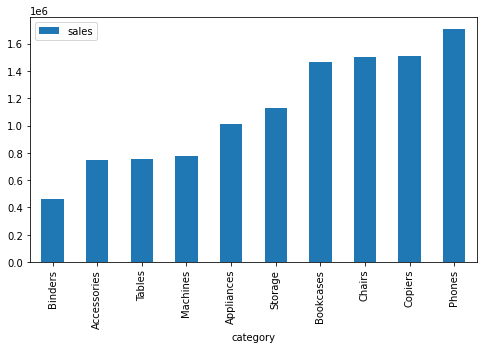

In [ ]:
plot_sum_by(data, 'sales', 'category', 10, True)

Categorias com os menores valores de vendas

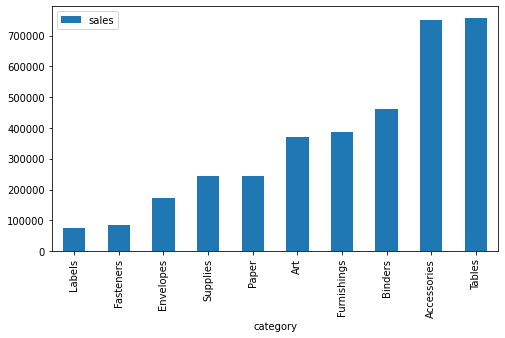

In [ ]:
plot_sum_by(data, 'sales', 'category', 10)

Valor de vendas por trimestre

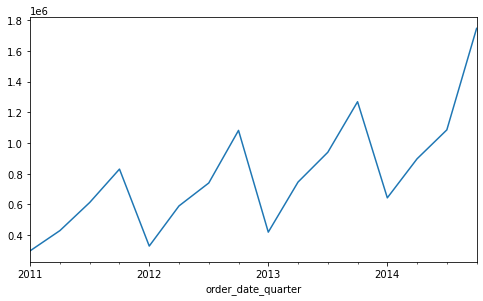

In [ ]:
subdata = pd.DataFrame()
subdata['order_date_quarter'] = pd.PeriodIndex(pd.to_datetime(data['order_date'].sort_values(ascending=False)), freq='Q')
subdata['sales'] = data['sales']
subdata = subdata.groupby('order_date_quarter')['sales'].sum()
subdata.plot(figsize=(8, 4.5))

#### 3. Qual é a quantidade de pedidos por região, mercado, categorias gerais e segmento? E quais países e categorias com mais e menos pedidos?

In [ ]:
subdata = data
subdata['orders'] = 1

Quantidade de pedidos por região

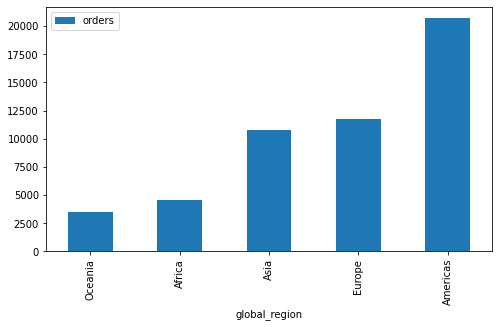

In [ ]:
plot_sum_by(subdata, 'orders', 'global_region')

Quantidade de pedidos por mercado

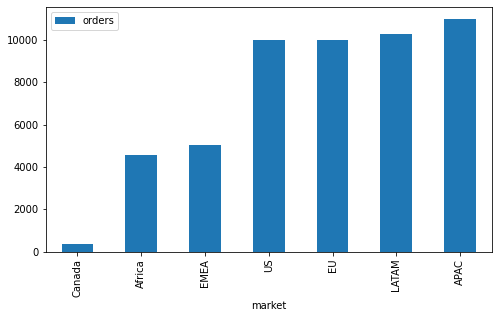

In [ ]:
plot_sum_by(data, 'orders', 'market')

Quantidade de pedidos por categorias gerais

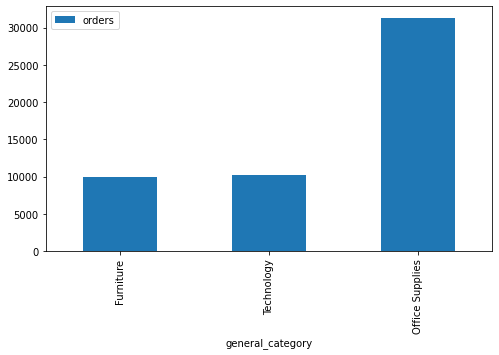

In [ ]:
plot_sum_by(data, 'orders', 'general_category')

Países com mais pedidos

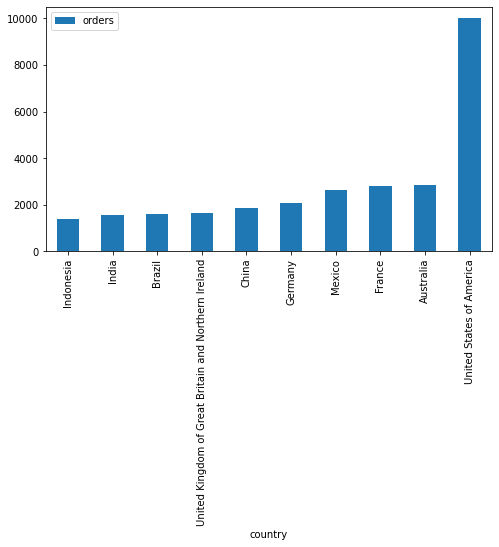

In [ ]:
plot_sum_by(data, 'orders', 'country', 10, True)

Países com menos pedidos

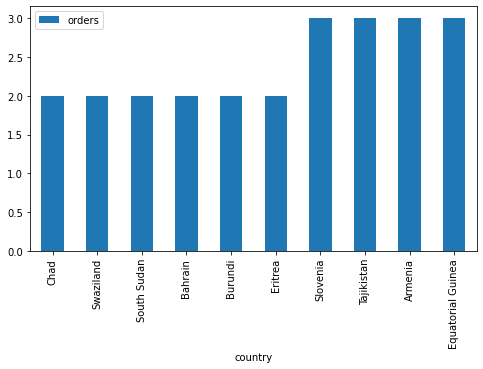

In [ ]:
plot_sum_by(data, 'orders', 'country', 10)

Categorias com mais pedidos

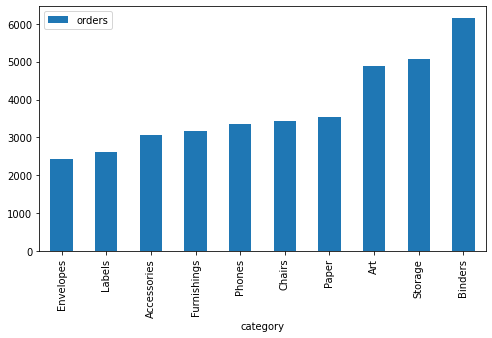

In [ ]:
plot_sum_by(data, 'orders', 'category', 10, True)

Categorias com menos pedidos

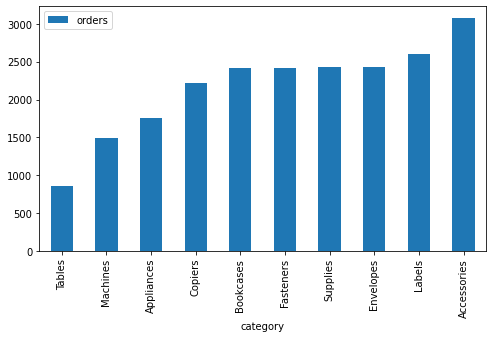

In [ ]:
plot_sum_by(data, 'orders', 'category', 10)

Volume trimestral de pedidos

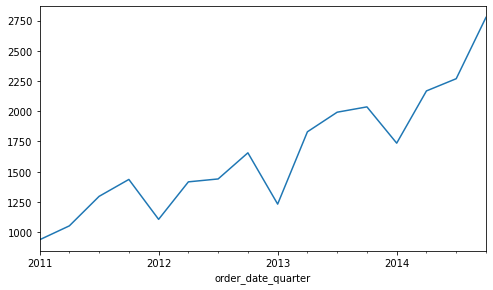

In [ ]:
subdata = pd.DataFrame()
subdata['order_date_quarter'] = pd.PeriodIndex(pd.to_datetime(data['order_date'].sort_values(ascending=False)), freq='Q')
subdata['id'] = data['order_id']
subdata = subdata.groupby('order_date_quarter')['id'].nunique()
subdata.plot(x='id', figsize=(8, 4.5))

#### 4. Quais as categorias predominantes em cada região?

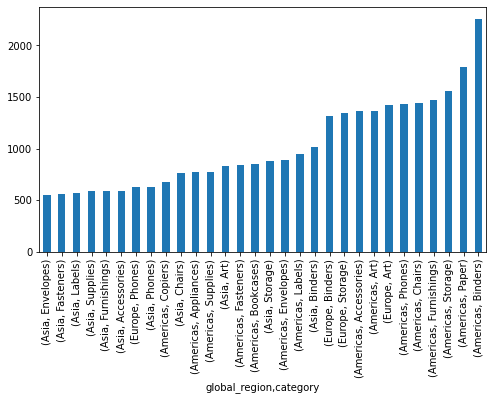

In [ ]:
subdata = pd.DataFrame()
subdata['id'] = data['order_id']
subdata['global_region'] = data['global_region']
subdata['category'] = data['category']
subdata = subdata.groupby(['global_region','category'])['id'].nunique()
subdata = subdata.sort_values(ascending=False)
subdata = subdata.head(30)
subdata = subdata.sort_values()
subdata.plot(kind='bar', figsize=(8, 4.5))

#### 5. Existem preferências no método de envio? E qual o método de envio predominante em cada região?

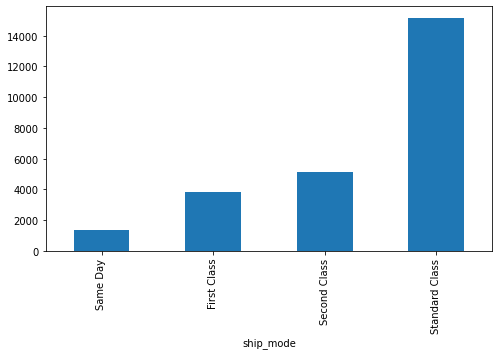

In [ ]:
subdata = pd.DataFrame()

subdata['ship_mode'] = data['ship_mode']
subdata['id'] = data['order_id']
subdata = subdata.groupby('ship_mode')['id'].nunique()
subdata = subdata.sort_values()
subdata.plot(kind='bar', figsize=(8, 4.5))

Preferência por região

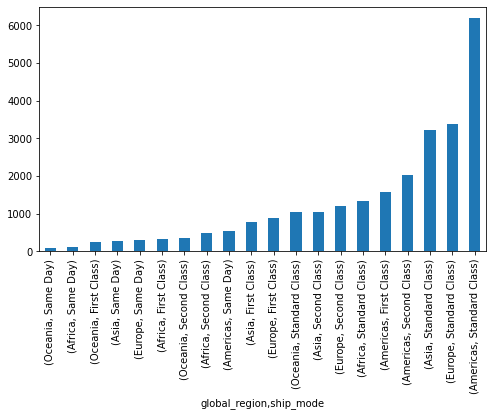

In [ ]:
subdata = pd.DataFrame()
subdata['id'] = data['order_id']
subdata['global_region'] = data['global_region']
subdata['ship_mode'] = data['ship_mode']
subdata = subdata.groupby(['global_region','ship_mode'])['id'].nunique()
subdata = subdata.sort_values(ascending=False)
subdata = subdata.sort_values()
subdata.plot(kind='bar', figsize=(8, 4.5))

Relação com a prioridade do pedido

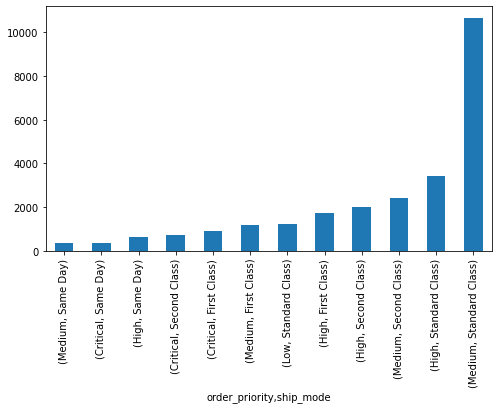

In [ ]:
subreg = pd.DataFrame()
subreg['id'] = data['order_id']
subreg['order_priority'] = data['order_priority']
subreg['ship_mode'] = data['ship_mode']
subreg = subreg.groupby(['order_priority','ship_mode'])['id'].nunique()
subreg = subreg.sort_values()
subreg.plot(kind='bar', figsize=(8, 4.5))

Relação com a época do ano

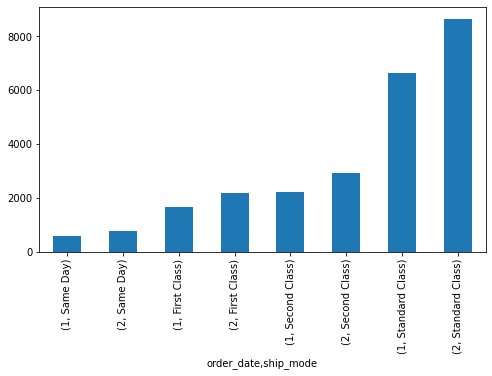

In [ ]:
subdate = pd.DataFrame()

#subdate['order_date_quarter'] = pd.PeriodIndex(pd.to_datetime(data['order_date'].sort_values(ascending=False)), freq='Q')
subdate['order_date'] = pd.to_datetime(data['order_date'])
subdate['order_date'].loc[subdate['order_date'].dt.month <= 6 ] = '1'
subdate['order_date'].loc[subdate['order_date'] != '1'  ] = '2'
subdate['id'] = data['order_id']
subdate['ship_mode'] = data['ship_mode']
subdate = subdate.groupby(['order_date','ship_mode'])['id'].nunique()
subdate = subdate.sort_values()
subdate.plot(kind='bar', figsize=(8, 4.5))

Relação com a região

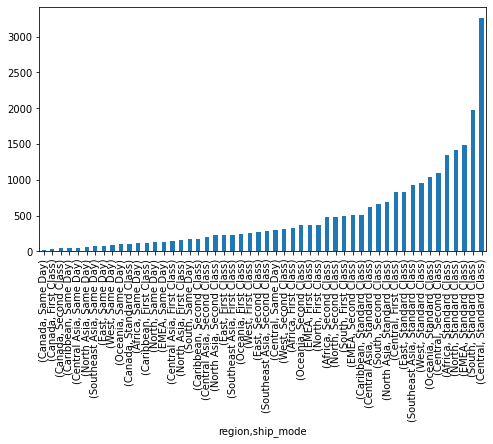

In [ ]:
subreg = pd.DataFrame()
subreg['id'] = data['order_id']
subreg['region'] = data['region']
subreg['ship_mode'] = data['ship_mode']
subreg = subreg.groupby(['region','ship_mode'])['id'].nunique()
subreg = subreg.sort_values()
subreg.plot(kind='bar', figsize=(8, 4.5))

Relação com o segmento.

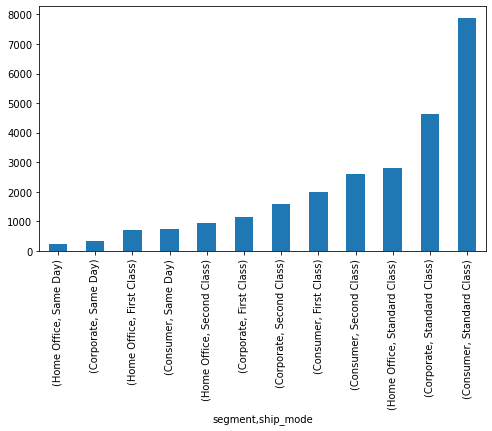

In [ ]:
subreg = pd.DataFrame()
subreg['id'] = data['order_id']
subreg['segment'] = data['segment']
subreg['ship_mode'] = data['ship_mode']
subreg = subreg.groupby(['segment','ship_mode'])['id'].nunique()
subreg = subreg.sort_values()
subreg.plot(kind='bar', figsize=(8, 4.5))

Segmento - Consumer

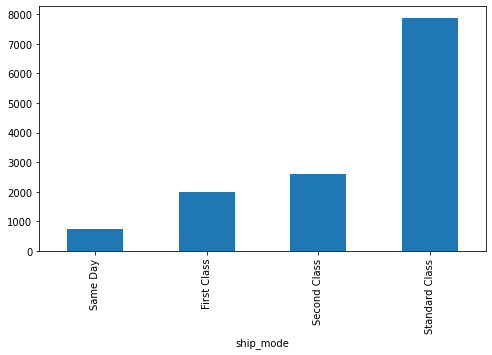

In [ ]:
segment_consumer = data[data.segment.eq("Consumer")]
sub_consumer = pd.DataFrame()
sub_consumer['ship_mode'] = segment_consumer['ship_mode']
sub_consumer['id'] = segment_consumer['order_id']
sub_consumer = sub_consumer.groupby('ship_mode')['id'].nunique()
sub_consumer = sub_consumer.sort_values()
sub_consumer.plot(kind='bar', figsize=(8, 4.5))

Segmento - Corporate

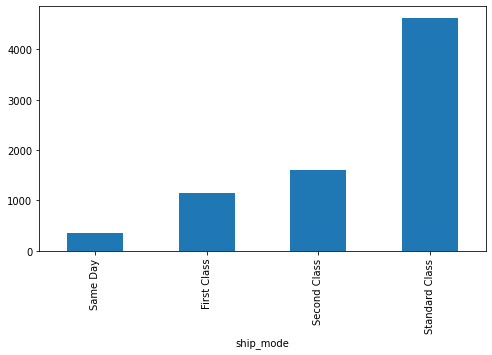

In [ ]:
segment_corporate = data[data.segment.eq("Corporate")]
sub_corporate = pd.DataFrame()
sub_corporate['ship_mode'] = segment_corporate['ship_mode']
sub_corporate['id'] = segment_corporate['order_id']
sub_corporate = sub_corporate.groupby('ship_mode')['id'].nunique()
sub_corporate = sub_corporate.sort_values()
sub_corporate.plot(kind='bar', figsize=(8, 4.5))

Segmento - Home Office

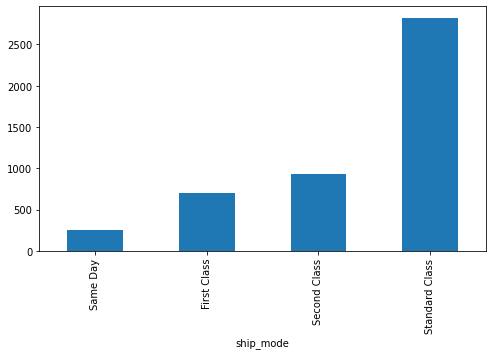

In [ ]:
segment_home_office = data[data.segment.eq("Home Office")]
sub_home_office = pd.DataFrame()
sub_home_office['ship_mode'] = segment_home_office['ship_mode']
sub_home_office['id'] = segment_home_office['order_id']
sub_home_office = sub_home_office.groupby('ship_mode')['id'].nunique()
sub_home_office = sub_home_office.sort_values()
sub_home_office.plot(kind='bar', figsize=(8, 4.5))

#### Quais subcategorias mantiveram o desempenho de vendas ao longo dos anos e regiões?

In [ ]:
subdate = pd.DataFrame()

subdate['order_date'] = pd.to_datetime(data['order_date'])
subdate['order_date'].loc[subdate['order_date'].dt.month <= 6 ] = '1'
subdate['order_date'].loc[subdate['order_date'] != '1'  ] = '2'
subdate['quantity'] = data['quantity']
subdate['category'] = data['category']


Primeiro Semestre

In [ ]:
subdate1 = subdate[subdate.order_date.eq("1")]
subdate1 = subdate1.groupby('subcategory').quantity.sum().reset_index()
subdate1.set_index('subcategory')
subdate1 = subdate1.sort_values('quantity')
subdate1.plot(x='subcategory', kind='bar', figsize=(8, 4.5))

Segundo Semestre

In [ ]:
subdate2 = subdate[subdate.order_date.eq("2")]
subdate2 = subdate2.groupby('subcategory').quantity.sum().reset_index()
subdate2.set_index('subcategory')
subdate2 = subdate2.sort_values('quantity')
subdate2.plot(x='subcategory', kind='bar', figsize=(8, 4.5))

In [ ]:

bookcases = pd.DataFrame()
bookcases = data[data.subcategory.eq("Storage")]
bookcases = bookcases[bookcases.global_region.eq("Americas")]
bookcases['order_date_quarter'] = pd.PeriodIndex(pd.to_datetime(bookcases['order_date'].sort_values(ascending=False)), freq='Q')
bookcases['id'] = data['order_id']
bookcases = bookcases.groupby('order_date_quarter')['id'].nunique()
bookcases.plot(kind = 'bar', figsize=(16, 4.5))


In [ ]:
#catergory = data.groupby(['category','sub-category'])['row_id'].count()
sub = data.groupby('global_region')['order_id'].count()
#city = data.groupby(['customer_id', 'customer_name'])['row_id'].count()
sub = sub.sort_values()
print(sub)

In [ ]:

#faixa de -500 a 500 de lucro
subdt = data[data.profit > 10 ]

subdt.describe()

Relação com a época do ano

In [ ]:
subdate = pd.DataFrame()

subdate['order_date'] = pd.to_datetime(data['order_date'])
subdate['order_date'].loc[subdate['order_date'].dt.month <= 6 ] = '1'
subdate['order_date'].loc[subdate['order_date'] != '1'  ] = '2'
subdate['profit'] = data['profit']
subdate['subcategory'] = data['subcategory']


Primeiro Semestre

In [ ]:
subdate = subdate[subdate.order_date.eq("1")]
subdate = subdate.groupby('subcategory').profit.sum().reset_index()
subdate.set_index('subcategory')
subdate = subdate.sort_values('profit')
subdate.plot(x='subcategory', kind='bar', figsize=(8, 4.5))

Segundo Semestre

In [ ]:
subdate = subdate[subdate.order_date.eq("2")]
subdate = subdate.groupby('subcategory').profit.sum().reset_index()
subdate.set_index('subcategory')
subdate = subdate.sort_values('profit')
subdate.plot(x='subcategory', kind='bar', figsize=(8, 4.5))

## Perguntas

### 1. Quais os atributos que impactam nos lucros? (Classificação)

In [ ]:
#filtrando dados de lucro muito discrepantes
#faixa de -500 a 500 de lucro tem a maioria dos dados
data = data[data.profit < 500 ]
data = data[data.profit > -500 ]

In [ ]:
# exemplo de chamada de função para fazer uma categorização
# categoria de lucro alto, médio e baixo
def profit_category(x):
    if x > 10:
        return 'H'
    elif x < 0:
        return 'L'
    else:
        return 'M'

def class_month(x):
    if x == 1:
        return 'Jan'
    if x == 2:
        return 'Fev'
    if x == 3:
        return 'Mar'
    if x == 4:
        return 'Abr'
    if x == 5:
        return 'Mai'
    if x == 6:
        return 'Jun'
    if x == 7:
        return 'Jul'
    if x == 8:
        return 'Ago'
    if x == 9:
        return 'Set'
    if x == 10:
        return 'Out'
    if x == 11:
        return 'Nov'
    else:
        return 'Dez'





#row_id,order_id,order_date,ship_date,ship_mode,customer_id,segment,city,state,
#country,market,region,product_id,category,subcategory,product_name,sales,quantity,
#discount,profit,shipping_cost,order_priority,global_region
#print(data['profit_category'] )
lucro = pd.DataFrame()
#lucro_data['order_date'] = data['order_date']
lucro['ship_mode'] = data['ship_mode']
lucro['segment'] = data['segment']
lucro['market_region'] = data['market'] + '_' +data['region']
lucro['category'] = data['category']
#lucro_data['gerenal_category'] = data['gerenal_category']
data['order_date'] = pd.to_datetime(data['order_date'])
#lucro_data['month'] = data['order_date'].loc[subdate['order_date'].dt.month <= 6 ]
lucro['month'] = ' '
lucro['month'] = data['order_date'].dt.month.map(class_month)
lucro['order_priority'] = data['order_priority']
lucro['global_region'] = data['global_region']
lucro['lucro'] = ' '
lucro['lucro'] = data['profit'].map(profit_category)
lucro.to_csv(os.path.join(drive_path, 'dataset_lucro_com_data' + file_ext), index=False)

lucro_data = pd.DataFrame()
#lucro_data['order_date'] = data['order_date']
lucro_data['ship_mode'] = data['ship_mode']
lucro_data['segment'] = data['segment']
lucro_data['market_region'] = data['market'] + '_' + data['region']
lucro_data['category'] = data['category']
#lucro_data['gerenal_category'] = data['gerenal_category']
#lucro_data['month'] = data['order_date'].loc[subdate['order_date'].dt.month <= 6 ]
lucro_data['order_priority'] = data['order_priority']
lucro_data['global_region'] = data['global_region']
lucro_data['lucro'] = ' '
lucro_data['lucro'] = data['profit'].map(profit_category)
lucro_data.to_csv(os.path.join(drive_path, 'dataset_lucro_sem_data' + file_ext), index=False)



In [ ]:
print(lucro_data.columns())

TypeError: ignored

Regras no algoritmo JRip

(order_priority = Critical) and (category = Storage) and (region = West) and segment = Consumer) => lucro=M (5.0/1.0)

(region = Southeast Asia) and (category = Tables) => lucro=L (37.0/3.0)

(region = Southeast Asia) and (category = Accessories) => lucro=L (53.0/13.0)

(category = Tables) and (region = East) => lucro=L (60.0/2.0)

(category = Tables) and (region = Central) and (market = EU) => lucro=L (37.0/10.0)

(region = Southeast Asia) and (segment = Corporate) and (category = Copiers) and (order_priority = Medium) => lucro=L (22.0/8.0)

(region = Oceania) and (category = Tables) => lucro=L (39.0/14.0)

(region = Southeast Asia) and (category = Art) => lucro=L (23.0/7.0)

 => lucro=H (14722.0/3806.0)

Number of Rules : 9

### 2. Existem categorias ou produtos que são costumeiramente vendidas juntas? (Associação)

#### Categoria

In [ ]:
# agrupa os produtos com as vendas
series = data.astype(str).groupby(['order_id'])['category'].apply(','.join)

In [ ]:
df2 = series.str.split(pat="," , n=-1, expand=True)
df2 = df2.fillna(value=np.nan)

In [ ]:
store_data = []
for sublist in df2.values.tolist():
  clean_sublist = [item for item in sublist if item is not np.nan]
  store_data.append(clean_sublist)

In [ ]:
te = TransactionEncoder()
te_ary = te.fit(store_data).transform(store_data) 
df3 = pd.DataFrame(te_ary, columns=te.columns_)

In [ ]:
# subistitui por valores mais leves
for col in df3:
  df3[col] = np.where(df3[col]==True, '1', '?')

In [ ]:
# salva a tabela
df3.to_csv(os.path.join(drive_path, '4_apriori' + file_ext), index=False)

Preparando colunas para utilizar no WEKA

In [ ]:
file = open(os.path.join(drive_path, 'header_raw.txt'))
fdata = file.read()
file.close()
tit = fdata.split(',')
fdata = '@RELATION products\n\n'
for t in tit:
  fdata += '@attribute ' + t + ' {1,0}\n'
fdata += '\n@data'
file = open(os.path.join(drive_path, 'header.txt'), 'w')
file.write(fdata)
file.close()

#### Produtos filtrados

In [ ]:
subdata = data.copy()

subdata = subdata.loc[subdata['category'].astype(str).isin(['Phones', 'Binders', 'Storage', 'Art'])]

In [ ]:
subdata.info()
#subdata.describe(include='all')

In [ ]:
# agrupa os produtos com as vendas
series = subdata.astype(str).groupby(['order_id'])['product_name'].apply(','.join)

In [ ]:
df2 = series.str.split(pat="," , n=-1, expand=True)
df2 = df2.fillna(value=np.nan)

In [ ]:
store_data = []
for sublist in df2.values.tolist():
  clean_sublist = [item for item in sublist if item is not np.nan]
  store_data.append(clean_sublist)

In [ ]:
te = TransactionEncoder()
te_ary = te.fit(store_data).transform(store_data) 
df3 = pd.DataFrame(te_ary, columns=te.columns_)

In [ ]:
# subistitui por valores mais leves
for col in df3:
  df3[col] = np.where(df3[col]==True, '1', '?')

In [ ]:
# salva a tabela
df3.to_csv(os.path.join(drive_path, '4_apriori_prod' + file_ext), index=False)

In [ ]:
file = open(os.path.join(drive_path, 'header_raw_prod.txt'))
fdata = file.read()
file.close()
fdata = fdata.replace('\'', '')
fdata = fdata.replace('"', '')
fdata = fdata.replace('-', '_')
fdata = fdata.replace('&', 'e')
fdata = fdata.replace('/', 'p')
fdata = fdata.replace('�', '_')
fdata = fdata.replace(' ', '_')
tit = fdata.split(',')
fdata = '@RELATION product_name\n\n'
for t in tit:
  fdata += '@attribute ' + t + ' {1,0}\n'
fdata += '\n@data'
file = open(os.path.join(drive_path, 'header_prod.txt'), 'w')
file.write(fdata)
file.close()

#### Produtos gerais

In [ ]:
# agrupa os produtos com as vendas
series = data.astype(str).groupby(['order_id'])['product_name'].apply(','.join)

In [ ]:
df2 = series.str.split(pat="," , n=-1, expand=True)
df2 = df2.fillna(value=np.nan)

In [ ]:
store_data = []
for sublist in df2.values.tolist():
  clean_sublist = [item for item in sublist if item is not np.nan]
  store_data.append(clean_sublist)

In [ ]:
te = TransactionEncoder()
te_ary = te.fit(store_data).transform(store_data) 
df3 = pd.DataFrame(te_ary, columns=te.columns_)

In [ ]:
# subistitui por valores mais leves
for col in df3:
  df3[col] = np.where(df3[col]==True, '1', '?')

In [ ]:
# salva a tabela
df3.to_csv(os.path.join(drive_path, '4_apriori_tot_prod' + file_ext), index=False)

In [ ]:
file = open(os.path.join(drive_path, '4_apriori_tot_prod' + file_ext))
fdata = file.readline()
edata = file.read().splitlines(True)
file.close()
fdata = fdata.replace('\'', '')
fdata = fdata.replace('"', '')
# fdata = fdata.replace('-', '_')
# fdata = fdata.replace('&', 'e')
# fdata = fdata.replace('/', 'p')
# fdata = fdata.replace('!', '')
fdata = fdata.replace('\r', '')
fdata = fdata.replace('\n', '')
fdata = fdata.replace('%', 'pc')
fdata = fdata.replace('�', '')
fdata = fdata.replace(' ', '_')
tit = fdata.split(',')
fdata = '@RELATION products\n\n'
for t in tit:
  fdata += '@attribute ' + t + ' {1,0}\n'
fdata += '\n@data\n'
file = open(os.path.join(drive_path, 'apriori_tot_prod.arff'), 'w')
file.write(fdata)
file.writelines(edata[1:])
file.close()